In [1]:
import numpy as np

class Connecta4:
    def __init__(self):
        self.board = np.zeros((6, 7), dtype=int)  # Tablero 6x7
        self.current_player = 1                  # Jugador 1 comienza
    
    def reset(self):
        self.board = np.zeros((6, 7), dtype=int)
        self.current_player = 1
        return self.board
    
    def step(self, action):
        # Acción es la columna donde colocar la ficha
        for row in range(5, -1, -1):  # De abajo hacia arriba
            if self.board[row, action] == 0:
                self.board[row, action] = self.current_player
                reward, done = self.check_winner(row, action)
                self.current_player = 3 - self.current_player  # Alterna entre 1 y 2
                return self.board, reward, done
        raise ValueError("Columna llena")
    
    def check_winner(self, row, col):
        # Comprobar si hay 4 en línea
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        for dr, dc in directions:
            count = 1
            for i in [-1, 1]:  # Direcciones opuestas
                for step in range(1, 4):
                    r, c = row + i * step * dr, col + i * step * dc
                    if 0 <= r < 6 and 0 <= c < 7 and self.board[r, c] == self.current_player:
                        count += 1
                    else:
                        break
                if count >= 4:
                    return 1, True  # Victoria
        if np.all(self.board != 0):
            return 0, True  # Empate
        return 0, False  # Juego continúa


In [2]:
import tensorflow as tf
import numpy as np
import random
from collections import deque

class DQLAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95         # Factor de descuento
        self.epsilon = 1.0        # Exploración inicial
        self.epsilon_min = 0.01   # Exploración mínima
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.memory = deque(maxlen=2000)
        self.model = self._build_model()
    
    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_dim=self.state_size),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Acción aleatoria
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])  # Acción con valor Q máximo

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


Episode 1/100, Total Reward: 1, Epsilon: 1.00
Episode 2/100, Total Reward: 1, Epsilon: 0.99
Episode 3/100, Total Reward: 1, Epsilon: 0.99
Episode 4/100, Total Reward: -69, Epsilon: 0.99
Episode 5/100, Total Reward: 1, Epsilon: 0.98
Episode 6/100, Total Reward: 1, Epsilon: 0.98
Episode 7/100, Total Reward: 1, Epsilon: 0.97
Episode 8/100, Total Reward: 1, Epsilon: 0.97
Episode 9/100, Total Reward: -49, Epsilon: 0.96
Episode 10/100, Total Reward: 1, Epsilon: 0.96
Episode 11/100, Total Reward: -99, Epsilon: 0.95
Episode 12/100, Total Reward: -19, Epsilon: 0.95
Episode 13/100, Total Reward: 1, Epsilon: 0.94
Episode 14/100, Total Reward: -79, Epsilon: 0.94
Episode 15/100, Total Reward: 1, Epsilon: 0.93
Episode 16/100, Total Reward: 1, Epsilon: 0.93
Episode 17/100, Total Reward: 1, Epsilon: 0.92
Episode 18/100, Total Reward: 1, Epsilon: 0.92
Episode 19/100, Total Reward: 1, Epsilon: 0.91
Episode 20/100, Total Reward: -49, Epsilon: 0.91
Episode 21/100, Total Reward: 1, Epsilon: 0.90
Episode 22

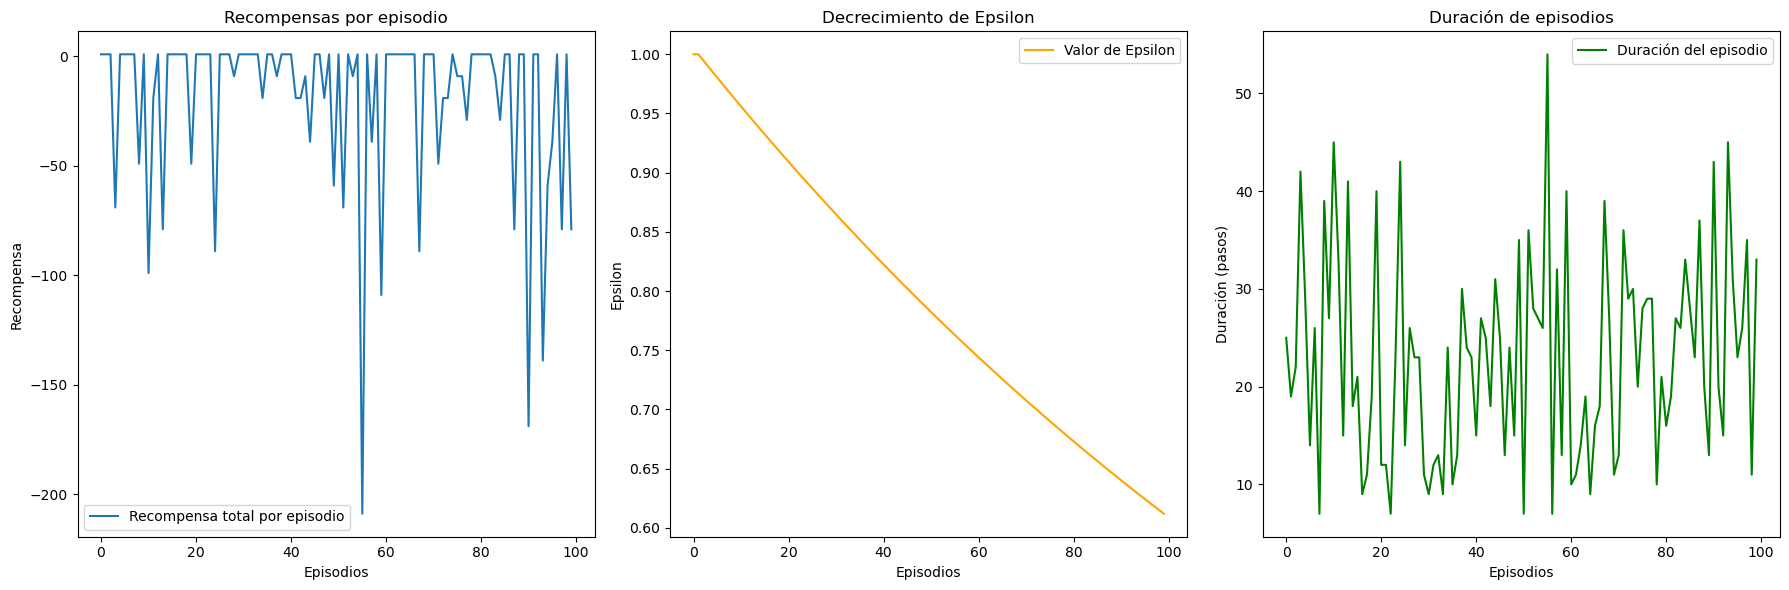

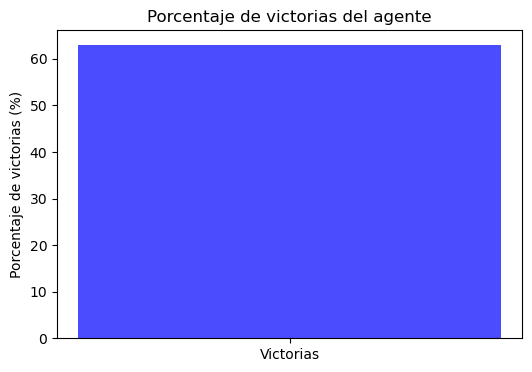

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Inicialización del entorno y agente
env = Connecta4()
agent = DQLAgent(state_size=6*7, action_size=7)

# Parámetros de entrenamiento
episodes = 100
batch_size = 32

# Métricas a rastrear
rewards = []  # Recompensa total por episodio
epsilon_values = []  # Valores de epsilon
win_rates = []  # Porcentaje de victorias cada N episodios
total_wins = 0  # Contador total de victorias
episode_lengths = []  # Duración de los episodios (número de turnos)

# Entrenamiento
for e in range(episodes):
    state = env.reset().flatten().reshape(1, -1)
    done = False
    total_reward = 0
    num_steps = 0  # Contador de turnos en el episodio

    while not done:
        num_steps += 1
        action = agent.act(state)
        try:
            next_state, reward, done = env.step(action)
            next_state = next_state.flatten().reshape(1, -1)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
        except ValueError:
            reward = -10  # Penalización por acción inválida
            total_reward += reward

    # Guardar métricas del episodio
    rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)
    episode_lengths.append(num_steps)
    if total_reward > 0:  # Gana si obtiene recompensa positiva
        total_wins += 1

    # Entrenamiento del agente
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

    print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

# Calcular porcentaje de victorias
win_rate = (total_wins / episodes) * 100
win_rates.append(win_rate)

# Imprimir total de victorias
print(f"Total de victorias: {total_wins}")

# Graficar métricas
plt.figure(figsize=(18, 6))

# Recompensas
plt.subplot(1, 3, 1)
plt.plot(rewards, label="Recompensa total por episodio")
plt.xlabel("Episodios")
plt.ylabel("Recompensa")
plt.title("Recompensas por episodio")
plt.legend()

# Epsilon
plt.subplot(1, 3, 2)
plt.plot(epsilon_values, label="Valor de Epsilon", color="orange")
plt.xlabel("Episodios")
plt.ylabel("Epsilon")
plt.title("Decrecimiento de Epsilon")
plt.legend()

# Duración de episodios
plt.subplot(1, 3, 3)
plt.plot(episode_lengths, label="Duración del episodio", color="green")
plt.xlabel("Episodios")
plt.ylabel("Duración (pasos)")
plt.title("Duración de episodios")
plt.legend()

plt.tight_layout()
plt.show()

# Graficar porcentaje de victorias
plt.figure(figsize=(6, 4))
plt.bar(["Victorias"], [win_rate], color="blue", alpha=0.7)
plt.ylabel("Porcentaje de victorias (%)")
plt.title("Porcentaje de victorias del agente")
plt.show()